In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def load_images_with_labels(folder_path, class_label, target_size=(224, 224)):
    """Load images from a folder and assign a class label."""
    image_arrays = []
    labels = []
    for filename in tqdm(os.listdir(folder_path), desc=f"Processing {class_label} images"):
        img_path = os.path.join(folder_path, filename)
        
        try:
            img = image.load_img(img_path, target_size=target_size)  # Resize
            img_array = image.img_to_array(img)  # Convert to array
            img_array = preprocess_input(img_array)
            image_arrays.append(img_array)
            labels.append(class_label)  # Append the corresponding label
            
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            continue

    return np.array(image_arrays), np.array(labels)

cats_folder = r'D:\Lab 5 dataset\Cat r\Cat r'  # Change to your actual path
dogs_folder = r'D:\Lab 5 dataset\Dog r\Dog r'  # Change to your actual path

# Load dog images and assign label 1
dog_images, dog_labels = load_images_with_labels(dogs_folder, class_label=1)

# Load cat images and assign label 0
cat_images, cat_labels = load_images_with_labels(cats_folder, class_label=0)

# Combine dog and cat images and labels
image_data = np.concatenate((dog_images, cat_images), axis=0)
labels = np.concatenate((dog_labels, cat_labels), axis=0)

# Print shapes to verify
print("Combined image data shape:", image_data.shape)  # Should be (num_dogs + num_cats, 224, 224, 3)
print("Combined labels shape:", labels.shape)  # Should be (num_dogs + num_cats,)

C:\Users\LENOVO\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Processing 0 images: 100%|█████████████████████████████████████████████████████████| 5990/5990 [01:52<00:00, 53.21it/s]


Combined image data shape: (11970, 224, 224, 3)
Combined labels shape: (11970,)


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and temporary (80% train, 20% temp)
xtrain, xtemp, ytrain, ytemp = train_test_split(
    image_data, labels, test_size=0.2, random_state=42, stratify=labels
)

# Now split the temporary set into validation and test sets (50% each of the temp set)
xval, xtest, yval, ytest = train_test_split(
    xtemp, ytemp, test_size=0.5, random_state=42, stratify=ytemp
)

# Print shapes of the splits to verify
print("Training data shape:", xtrain.shape)  # (train_samples, 224, 224, 3)
print("Training labels shape:", ytrain.shape)  # (train_samples,)
print("Validation data shape:", xval.shape)  # (val_samples, 224, 224, 3)
print("Validation labels shape:", yval.shape)  # (val_samples,)
print("Test data shape:", xtest.shape)  # (test_samples, 224, 224, 3)
print("Test labels shape:", ytest.shape)  # (test_samples,)

Training data shape: (9576, 224, 224, 3)
Training labels shape: (9576,)
Validation data shape: (1197, 224, 224, 3)
Validation labels shape: (1197,)
Test data shape: (1197, 224, 224, 3)
Test labels shape: (1197,)


In [7]:
del image_data
del labels

In [9]:
import tensorflow as tf
import keras

In [11]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top
for layer in base_model.layers:
    layer.trainable=False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 53s 1us/step


In [12]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

x = Flatten()(base_model.output)  # Flatten the output of the base model
x = Dense(256, activation='relu')(x)  # Add a dense layer with 256 units
x = Dense(2, activation='softmax')(x)  # Output layer for 2 classes

# Create the complete model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if one-hot encoding
              metrics=['accuracy'])

# Print the model summary to verify the architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
history = model.fit(xtrain, ytrain, 
                    validation_data=(xval, yval), 
                    epochs=2,  # Adjust the number of epochs as needed
                    batch_size=100)  # Adjust the batch size as needed

Epoch 1/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 4122s 43s/step - accuracy: 0.7978 - loss: 22.6856 - val_accuracy: 0.9766 - val_loss: 0.0718
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 3355s 35s/step - accuracy: 0.9894 - loss: 0.0340 - val_accuracy: 0.9816 - val_loss: 0.0607


In [16]:
ypredprobs = model.predict(xtest)  # Predict probabilities
ypred = np.argmax(ypredprobs, axis=1)  # Convert probabilities to class labels (0 or 1)

# Print the predicted labels
print("Predicted labels:", ypred)

# Optionally, you can compare with the true labels (y_test)
print("True labels:", ytest)

# Evaluate the model performance on the test data
test_loss, test_accuracy = model.evaluate(xtest, ytest, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 350s 9s/step
Predicted labels: [1 1 0 ... 1 1 1]
True labels: [1 1 0 ... 1 1 1]
38/38 ━━━━━━━━━━━━━━━━━━━━ 349s 9s/step - accuracy: 0.9854 - loss: 0.0440
Test Accuracy: 98.33%


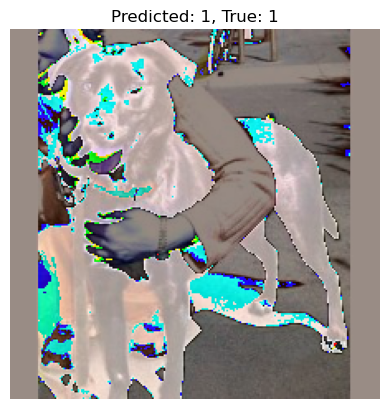

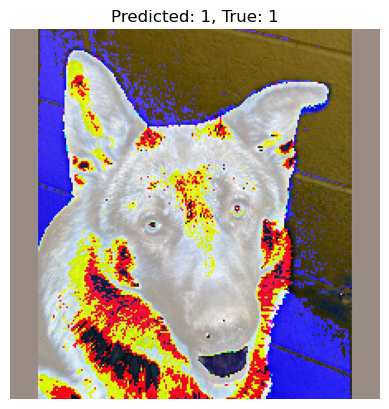

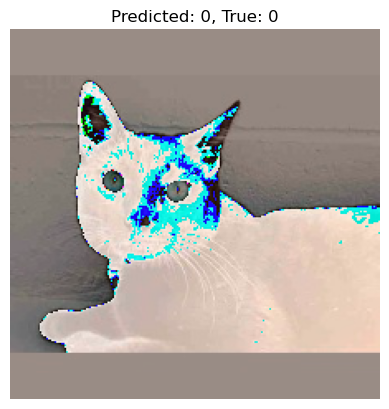

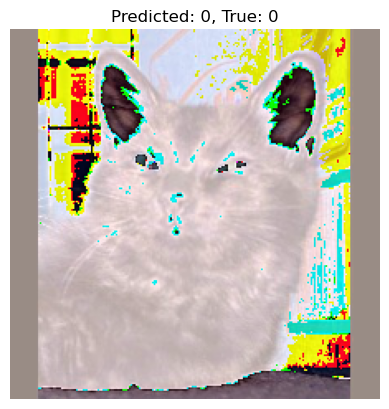

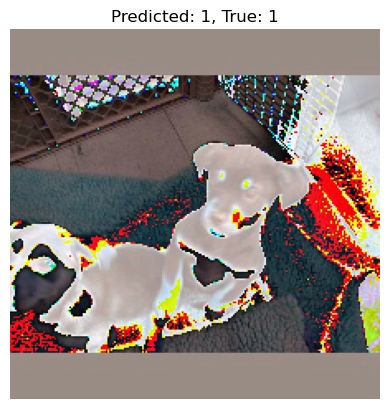

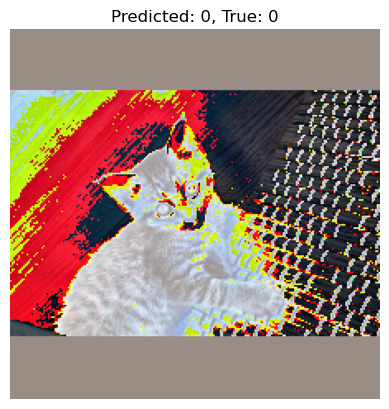

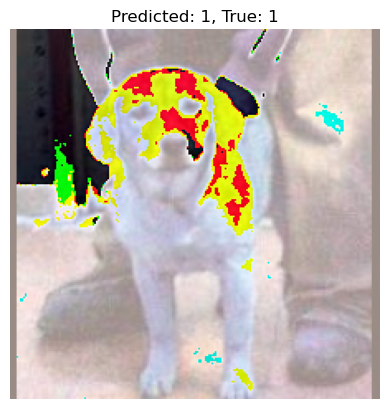

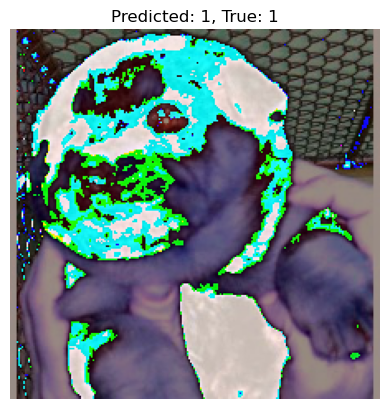

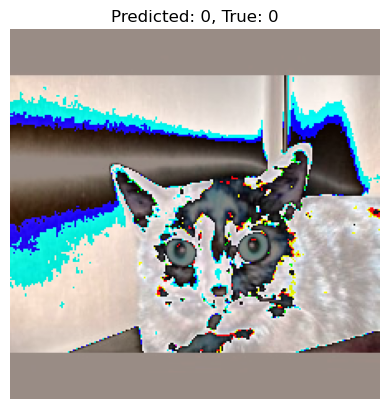

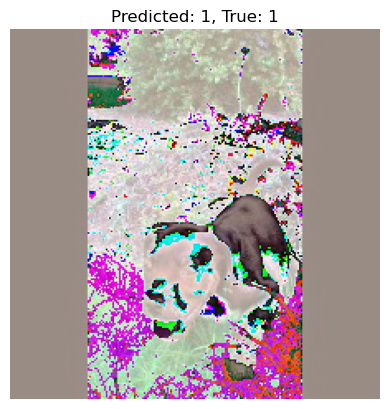

In [17]:
import matplotlib.pyplot as plt

# Visualize a few test images along with their predicted and true labels
for i in range(10):  # Display 5 test images
    plt.imshow(xtest[i].astype("uint8"))  # Show the image
    plt.title(f"Predicted: {ypred[i]}, True: {ytest[i]}")
    plt.axis('off')
    plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(ytest, ypred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1-Score
precision = precision_score(ytest, ypred)
recall = recall_score(ytest, ypred)
f1 = f1_score(ytest, ypred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, ypred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 98.33%
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Confusion Matrix:
[[589  10]
 [ 10 588]]
